# **Inviscid Burger Equation Solver Using Finite Folume Method**

**Final Project of AE5011 Computational Fluid Dynamics**

By:

Michael Agung Nugroho     23622009

Nayottama Putra Suherman  23622016

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class Grid:
  def __init__(self, Np, Mp, Ng=2, Mg=2, xmin=0, xmax=1, ymin=0, ymax=1):
    self.Np = Np
    self.Ng = Ng
    self.Mp = Mp
    self.Mg = Mg

    self.xmin = xmin
    self.xmax = xmax
    self.ymin = ymin
    self.ymax = ymax

    self.dx = (xmax-xmin)/(Np-1)
    self.dy = (ymax-ymin)/(Mp-1)

    self.xcmin = self.xmin+self.dx/2
    self.xcmax = self.xmax-self.dx/2
    self.ycmin = self.ymin+self.dy/2
    self.ycmax = self.ymax-self.dy/2

    self.xi = np.linspace(0, 1, Np)
    self.xic = np.linspace(0, 1, Np-1)
    self.eta = np.linspace(0, 1, Mp)
    self.etac = np.linspace(0, 1, Mp-1)

  def TFI_2D_FVM(self):
    xx = np.zeros((self.Np,self.Mp))
    yy = np.zeros((self.Np,self.Mp))
    xc = np.zeros((self.Np-1,self.Mp-1))
    yc = np.zeros((self.Np-1,self.Mp-1))

    #Grid Generation
    for i in range(self.Np):
      for j in range(self.Mp):
        UX = (1-self.xi[i])*self.xmin+ self.xi[i]*self.xmax
        VY = (1-self.eta[j])*self.ymin + self.eta[j]*self.ymax
        UY = (1-self.xi[i])*VY + self.xi[i]*VY        
        VX = (1-self.eta[j])*UX + self.eta[j]*UX

        UVX = ((1-self.xi[i])*(1-self.eta[j])*self.xmin + self.xi[i]*(1-self.eta[j])*self.xmax + 
              (1-self.xi[i])*self.eta[j]*self.xmin + self.xi[i]*self.eta[j]*self.xmax)
        UVY = ((1-self.xi[i])*(1-self.eta[j])*self.ymin + self.xi[i]*(1-self.eta[j])*self.ymin + 
              (1-self.xi[i])*self.eta[j]*self.ymax + self.xi[i]*self.eta[j]*self.ymax)
        
        xx[i][j] = UX + VX - UVX
        yy[i][j] = UY + VY - UVY

    #Center point generation
    for i in range(self.Np-1):
      for j in range(self.Mp-1):
        UXc = (1-self.xic[i])*self.xcmin+ self.xic[i]*self.xcmax
        VYc = (1-self.etac[j])*self.ycmin + self.etac[j]*self.ycmax
        UYc = (1-self.xic[i])*VYc + self.xic[i]*VYc        
        VXc = (1-self.etac[j])*UXc + self.etac[j]*UXc

        UVXc = ((1-self.xic[i])*(1-self.etac[j])*self.xcmin + self.xic[i]*(1-self.etac[j])*self.xcmax + 
              (1-self.xic[i])*self.etac[j]*self.xcmin + self.xic[i]*self.etac[j]*self.xcmax)
        UVYc = ((1-self.xic[i])*(1-self.etac[j])*self.ycmin + self.xic[i]*(1-self.etac[j])*self.ycmin + 
              (1-self.xic[i])*self.etac[j]*self.ycmax + self.xic[i]*self.etac[j]*self.ycmax)
        
        xc[i][j] = UXc + VXc - UVXc
        yc[i][j] = UYc + VYc - UVYc

    return (xx, yy, xc, yc)

In [ ]:
def calc_E_F(U_cell, E_surf_x, F_surf_x, E_surf_y, F_surf_y, U_left, U_right, U_bot, U_top):
  Nx = len(E_surf_x)
  nx = len(E_surf_y)

  Ny = len(E_surf_y[0])
  ny = len(E_surf_x[0])
  
  for i in range(Nx):
    for j in range(ny):
      if (i == 0):
        E_surf_x[i,j] = 0.25*U_cell[i,j]**2 + 0.25*U_left[j]**2
        F_surf_x[i,j] = 0.5*U_cell[i,j] + 0.5*U_left[j]
      elif (i == Nx-1):
        E_surf_x[i,j] = 0.25*U_cell[i-1,j]**2 + 0.25*U_right[j]**2
        F_surf_x[i,j] = 0.5*U_cell[i-1,j] + 0.5*U_right[j]
      else:
        E_surf_x[i,j] = 0.25*U_cell[i,j]**2 + 0.25*U_cell[i-1,j]**2
        F_surf_x[i,j] = 0.5*U_cell[i,j] + 0.5*U_cell[i-1,j]

  for i in range(nx):
    for j in range(Ny):
      if (j == 0):
        E_surf_y[i,j] = 0.25*U_cell[i,j]**2 + 0.25*U_bot[i]**2
        F_surf_y[i,j] = 0.5*U_cell[i,j] + 0.5*U_bot[i]
      elif (j == Ny-1):
        E_surf_y[i,j] = 0.25*U_cell[i,j-1]**2 + 0.25*U_top[i]**2
        F_surf_y[i,j] = 0.5*U_cell[i,j-1] + 0.5*U_top[i]
      else:
        E_surf_y[i,j] = 0.25*U_cell[i,j]**2 + 0.25*U_cell[i,j-1]**2
        F_surf_y[i,j] = 0.5*U_cell[i,j] + 0.5*U_cell[i,j-1]

  return E_surf_x, F_surf_x, E_surf_y, F_surf_y

def calc_flux(Flux, E_surf_x, F_surf_x, E_surf_y, F_surf_y, dt, dx, dy):

  nx = len(Flux)
  ny = len(Flux[0])

  dUdt = 0

  for i in range(nx):
    for j in range(ny):

      Flux[i,j] = -(E_surf_x[i+1,j]/dx - E_surf_x[i,j]/dx + F_surf_y[i,j+1]/dy - F_surf_y[i,j]/dy)*dt
      dUdt += abs(E_surf_x[i+1,j] - E_surf_x[i,j] + F_surf_y[i,j+1] - F_surf_y[i,j])

  return Flux, dUdt

def Averaged_U(U_cell, U_left, U_right, U_bot, U_top):

  nx = len(U_cell)
  ny = len(U_cell[0])

  U_ave =np.zeros([nx,ny])

  for i in range(nx):
    for j in range(ny):

      if (i == 0):
        U_ave[i,j] += 0.25*U_left[j]
      else:
        U_ave[i,j] += 0.25*U_cell[i-1,j]

      if (i == nx-1):
        U_ave[i,j] += 0.25*U_right[j]
      else:
        U_ave[i,j] += 0.25*U_cell[i+1,j]

      if (j == 0):
        U_ave[i,j] += 0.25*U_bot[i]
      else:
        U_ave[i,j] += 0.25*U_cell[i,j-1]

      if (j == ny-1):
        U_ave[i,j] += 0.25*U_top[j]
      else:
        U_ave[i,j] += 0.25*U_cell[i,j+1]

  return U_ave

def Integration(U_cell, U_ave, Flux):

  U_cell = U_ave+Flux

  return U_cell

In [ ]:
def calc_analytic(x_cell,y_cell):

  nx = len(x_cell)
  ny = len (x_cell[0])
  analytic = np.zeros([nx,ny])

  for i in range(nx):
    for j in range(ny):

      if (y_cell[i,j] <= 0.5):
        if (x_cell[i,j] <= 1.5*y_cell[i,j]):
          analytic[i,j] = 1.5
        elif (1.5*y_cell[i,j] <= x_cell[i,j] <= (1-0.5*y_cell[i,j])):
          analytic[i,j] = (1.5-2*x_cell[i,j])/(1-2*y_cell[i,j])
        elif (x_cell[i,j] >= 1-0.5*y_cell[i,j]):
          analytic[i,j] = -0.5
      elif (y_cell[i,j] >= 0.5):
        if (x_cell[i,j] <= 0.5+0.5*y_cell[i,j]):
          analytic[i,j] = 1.5
        else:
          analytic[i,j] = -0.5


  return analytic

In [ ]:
def calc_L2(U_cell, analytic):

  nx = len(U_cell)
  ny = len(U_cell[0])


  numerator = 0
  denum = 0
  for i in range(nx):
    for j in range(ny):

      numerator += abs(analytic[i,j] - U_cell[i,j])**2
      denum += analytic[i,j]**2

  return np.sqrt(numerator/denum)

def calc_difference(U_cell, U_new):

  nx = len(U_cell)
  ny = len(U_cell[0])

  diff = 0
  for i in range(nx):
    for j in range(ny):

      diff += abs(U_new[i,j] - U_cell[i,j])

  return diff/(nx*ny)

In [ ]:
# Domain
x0 = 0
x1 = 1
y0 = 0
y1 = 1

# Number of Nodes
Nx = 41
Ny = 41

# Number of Cell
nx = Nx-1
ny = Ny-1

In [ ]:
# Create Coordinate Matrix

dx = (x1-x0)/nx
dy = (y1-y0)/ny

TFI_grid = Grid(Nx, Ny, xmin=0, xmax=1, ymin=0, ymax=1)
x_nodes, y_nodes, x_cell, y_cell = TFI_grid.TFI_2D_FVM()

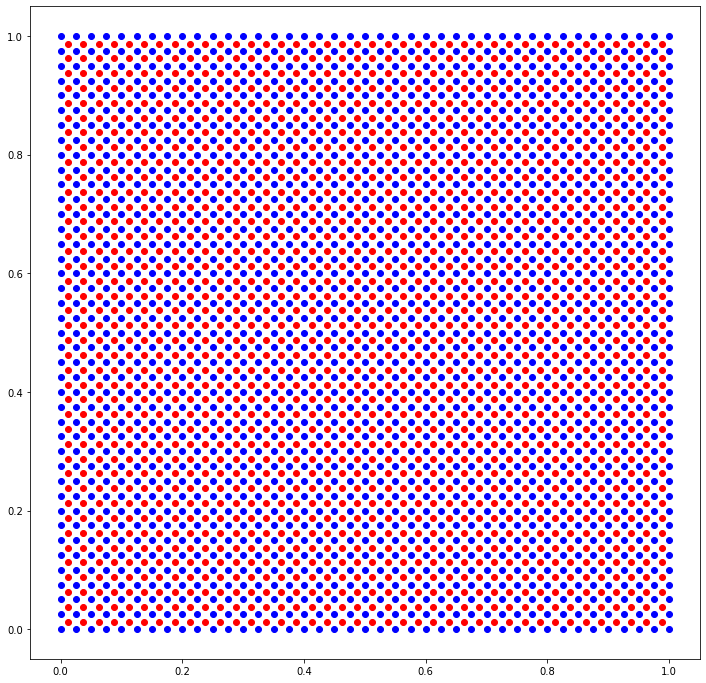

In [ ]:
fig,ax = plt.subplots(figsize = (12,12))

plt.scatter(np.resize(x_nodes,(Nx*Ny,1)),np.resize(y_nodes,(Nx*Ny,1)), c = "b")
plt.scatter(np.resize(x_cell,(nx*ny,1)),np.resize(y_cell,(nx*ny,1)), c = "r")

In [ ]:
# Create Properties Matrix

U_cell = np.zeros([nx,ny])
U_new  = np.zeros([nx,ny])

E_surf_x = np.empty([Nx,ny])
F_surf_x = np.empty([Nx,ny])

E_surf_y = np.empty([nx,Ny])
F_surf_y = np.empty([nx,Ny])

# Boundary Condition

U_left  = np.empty([ny])
U_right = np.empty([ny])

U_bot = np.empty([nx])
U_top = np.empty([nx])



U_top[:] = U_cell[:,ny-2]
U_cell[:,-1] = U_cell[:,-2]
U_bot[:] = 1.5 - 2*x_cell[:,0]

U_left[:]  = 1.5
U_right[:] = -0.5

# Define Flux

Flux = np.empty([nx,ny])

In [ ]:
# Simulation Parameter

max_iter = 1000
dt = dx/2.5

threshold = 0.00001

flux_history = []

# Simulation

iter = 0
while(True):

  E_surf_x, F_surf_x, E_surf_y, F_surf_y = calc_E_F(U_cell, E_surf_x, F_surf_x, E_surf_y, F_surf_y, U_left, U_right, U_bot, U_top)

  Flux, dUdt = calc_flux(Flux, E_surf_x, F_surf_x, E_surf_y, F_surf_y, dt, dx, dy)

  U_ave = Averaged_U(U_cell, U_left, U_right, U_bot, U_top)

  U_new = Integration(U_new, U_ave, Flux)

  U_top[:] = U_new[:,ny-2]
  U_new[:,-1] = U_new[:,-2]

  diff = calc_difference(U_new, U_cell)

  flux_history = np.append(flux_history, diff)  

  U_cell = U_new

  iter += 1

  if ((iter > max_iter) or (diff < threshold)):
    break

analytic = calc_analytic(x_cell, y_cell)
error = calc_L2(U_cell, analytic)

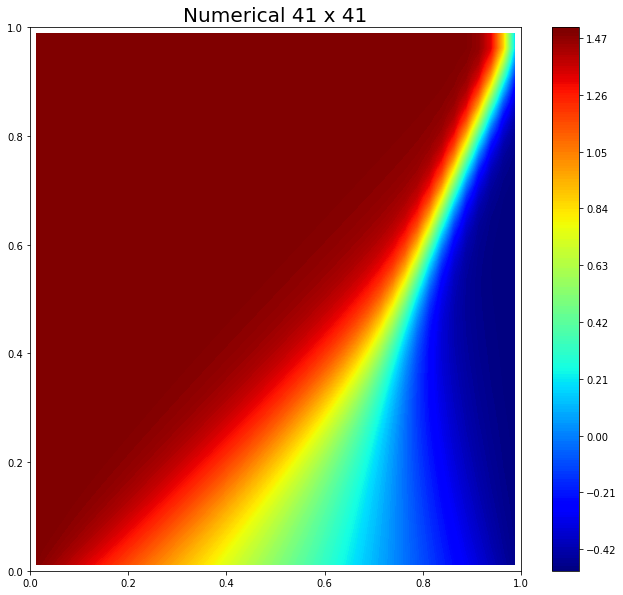

In [ ]:
fig,ax = plt.subplots(figsize=(11,10))

scatter = ax.contourf(x_cell, y_cell, U_cell, cmap = "jet", levels = 201, vmin = -0.5, vmax = 1.5)
# plt.scatter(x_cell, y_cell, c='k', s = 1)

# scatter = ax.scatter(np.resize(x_cell,(nx*ny,1)), np.resize(y_cell,(nx*ny,1)), c = np.resize(U_cell,(nx*ny,1)), cmap = "jet", s = 125)

plt.title("Numerical %d x %d" %(Nx, Ny), fontsize = 20)
plt.xlim([0,1])
plt.ylim([0,1])
cbar = fig.colorbar(scatter)

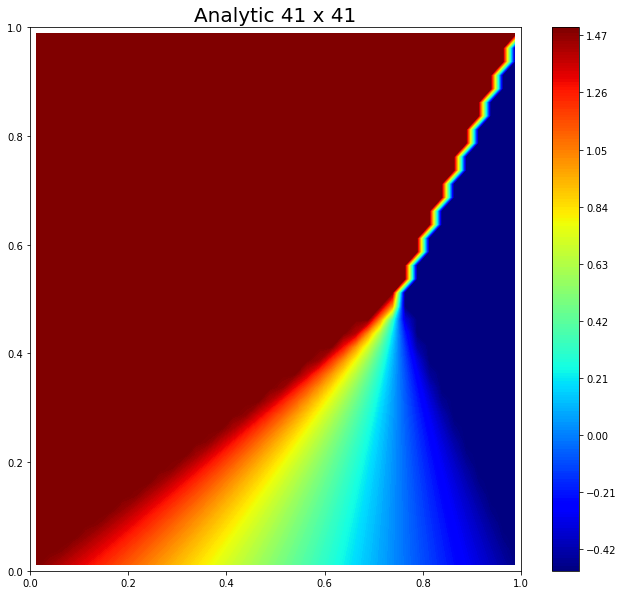

In [ ]:
fig2,ax2 = plt.subplots(figsize=(11,10))

scatter2 = ax2.contourf(x_cell, y_cell, analytic, cmap = "jet", levels = 201, vmin = -0.5, vmax = 1.5)
# plt.scatter(x_cell, y_cell, c='k', s = 1)

# scatter = ax2.scatter(np.resize(x_cell,(nx*ny,1)), np.resize(y_cell,(nx*ny,1)), c = np.resize(U_cell,(nx*ny,1)), cmap = "jet", s = 125)

plt.title("Analytic %d x %d" %(Nx, Ny), fontsize = 20)
plt.xlim([0,1])
plt.ylim([0,1])
cbar = fig2.colorbar(scatter2)

In [ ]:
error

0.12287930912544723

(0.04, 0.18)

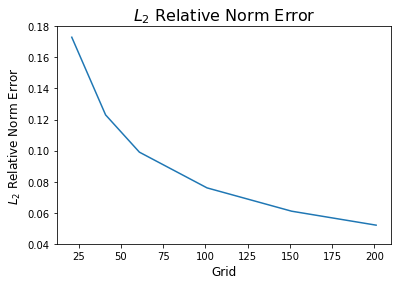

In [ ]:
L2 = [0.173, 0.123, 0.099, 0.076, 0.061, 0.052]
grid = [21,41,61,101,151,201]

fig3,ax3 = plt.subplots(figsize=(6,4))

plot = ax3.plot(grid, L2)

plt.title("$L_{2}$ Relative Norm Error", fontsize = 16)
plt.xlabel ("Grid", fontsize = 12)
plt.ylabel ("$L_{2}$ Relative Norm Error", fontsize = 12)
plt.ylim([0.04,0.18])

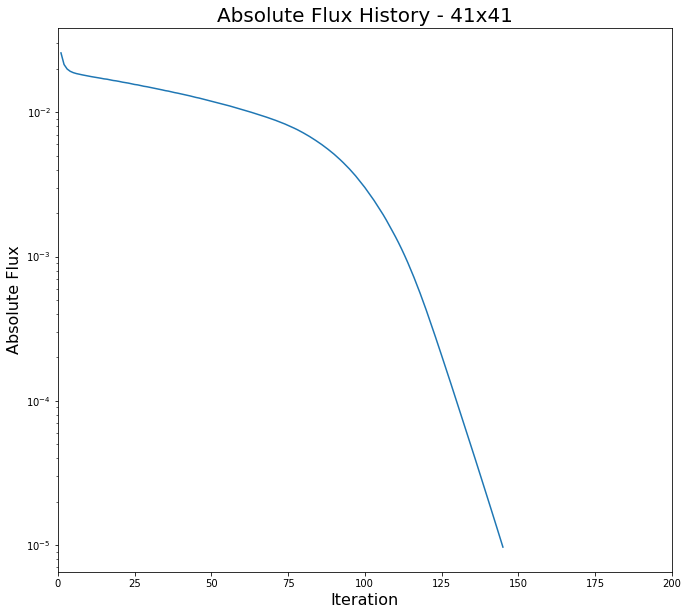

In [ ]:
fig4,ax4 = plt.subplots(figsize=(11,10))

plot = ax4.plot(range(1, 1+len(flux_history)),flux_history)

plt.title("Absolute Flux History - %dx%d" %(Nx,Ny), fontsize = 20)
plt.xlabel ("Iteration", fontsize = 16)
plt.xlim ([0,np.ceil(len(flux_history)/100)*100])

plt.ylabel ("Absolute Flux", fontsize = 16)
plt.yscale ("log")

In [ ]:
diff

9.69214062971611e-06

In [ ]:
len(flux_history)

145

In [ ]:
y_cell

array([[0.0125, 0.0375, 0.0625, ..., 0.9375, 0.9625, 0.9875],
       [0.0125, 0.0375, 0.0625, ..., 0.9375, 0.9625, 0.9875],
       [0.0125, 0.0375, 0.0625, ..., 0.9375, 0.9625, 0.9875],
       ...,
       [0.0125, 0.0375, 0.0625, ..., 0.9375, 0.9625, 0.9875],
       [0.0125, 0.0375, 0.0625, ..., 0.9375, 0.9625, 0.9875],
       [0.0125, 0.0375, 0.0625, ..., 0.9375, 0.9625, 0.9875]])